<a href="https://colab.research.google.com/github/JAaron93/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/Fixed_Lecture_NB_DS16_LS_DS_433_Autoencoders_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process gis described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

![](https://miro.medium.com/max/3110/0*uq2_ZipB9TqI9G_k)

## Follow Along
### Extremely Simple Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import os
%load_ext tensorboard

# needed to update link
# use this link, here -- it works! 
URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

# create directory to store images that we'll we will be using to train out auto-encoders 
path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

25427968/25421363 [==============================] - 0s 0us/step


In [2]:
data = np.load(path_to_zip)

x_train = data['arr_0']
y_train = data['arr_1']

print(x_train.shape)
print(y_train.shape)

(100000, 784)
(100000,)


In [3]:
# data is loaded in already as 1D row vectors 
x_train[0].shape

(784,)

In [4]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

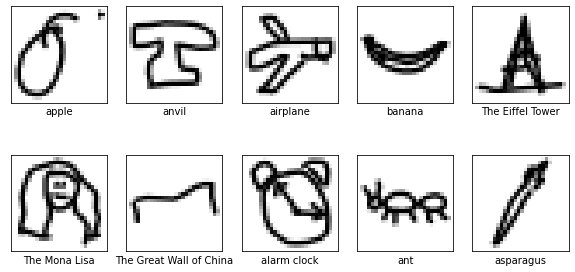

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

# helper function used to plot images 
for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show()

### Prep data

In [6]:
from sklearn.utils import shuffle
# Shuffle
# also a good idea to suffice data before using it to build a model
x_train, y_train = shuffle(x_train, y_train)

# Normalize 
# we are scaling the pixel values between 0 and 1 by dividing by the largest pixel value (i.e. 255)
max_pixel_value = x_train.max()
x_train = x_train.astype('float32') / max_pixel_value
print(x_train.shape)

(100000, 784)


In [7]:
# Check that our pixel values are indeed normalized 
assert x_train.min() == 0.0
assert x_train.max() == 1.0

In [8]:
# YOUR CODE HERE
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [9]:
# build simple auto-encoder

# save input data dimensions to variable
input_dims = x_train.shape[1]
shape = (input_dims,)

# decoder dimensions (i.e. 784 dimensions)
decoding_dim = input_dims

# encoder output dimensions
latent_vect_dims = 32

# create input layer
inputs = Input(shape=shape)

# create encoder layer
# We can think of each layer as an individual function y = f(x)
# We don't think of f(x) as f times x, so don't think of this as Dense times x


# y = f(x) <=> layer_output = Dense(parameters)(layer_input)
# Dense layer is a mathematical function with inputs that are passed into it so
# that it may give outputs. 
# We can even concieve of neural networks as composite functions

# With a Model class we have to give an extra 'layer of clarity' considering the 
# flexibility of the NN architecture we can build in contrast to the simple, 
# yet limited architectonics of the Sequential Class

# What comes from the inputs layer will go into the encoder layer
encoded = Dense(latent_vect_dims, activation="relu")(inputs)

# create decoder layer
# compressed vector we pass in has to be decoded/uncompressed. It does this to reconstruct the original image
decoded =  Dense(decoding_dim, activation="sigmoid")(encoded)

# bring it all together using the model API. inputs is the original image, and outputs is our reconstructed image with some layers inbetween them
# Now we're using the Model class. Allows more flexibility for how we build our models.
# 
autoencoder_simple = Model(inputs=inputs, outputs=decoded, name="simple_autoencoder")

In [10]:
# compiling our Model class model
autoencoder_simple.compile(optimizer='nadam', loss='binary_crossentropy')

In [11]:
autoencoder_simple.summary()
# Here we can see that the dimensions of our image were 784, were compressed to 32,
# before being reconstructed with its original 784 dimensions by the final/output layer

Model: "simple_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [12]:
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

# cut off training if loss doesn't decrease by a certain amount over X number of epoches 
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"SimpleAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder_simple.fit(x_train, # input image to encoder
                x_train, # provide input image to decoder so the model learns how to reconstruct the input image 
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/100
1250/1250 [==============================] - 6s 3ms/step - loss: 0.2935 - val_loss: 0.2430
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2333 - val_loss: 0.2282
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2255 - val_loss: 0.2245
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2234 - val_loss: 0.2236
Epoch 5/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2227 - val_loss: 0.2229
Epoch 6/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2223 - val_loss: 0.2225
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2221 - val_loss: 0.2223


### Use Trained Model to Reconstruct Images


In [13]:
# encode and decode some images
# original images go in (i.e, x_train) and decoded images come out (i.e. a non-perfect reconstruction of x_train)
decoded_imgs = autoencoder_simple(x_train)

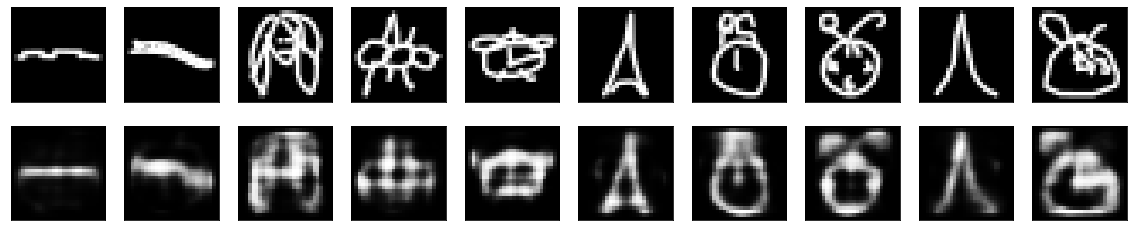

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

### helper fuction for plotting reconstructed and original images 
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

### Deep Autoencoder

In [18]:
#                                encoder     ->    decoder 
# dim of each hidden layer: 784, 128, 64, 32 -> 64, 128, 784

# YOUR CODE HERE
# input layer
inputs = Input(shape=(784,))

# 1st encoding layer. Inputs to the first Dense layer are the original input dimensions
# Compresses input image into 128 dimension vector
encoded_1 = Dense(128, activation="relu")(inputs)

# 2nd encoding layer
# Compresses 128 dim vect into 64 dim vect
encoded_2 = Dense(64, activation="relu")(encoded_1)

# 3rd encoding layer
# Compresses 64 dim vect into 32 dim vect
# This is the final compression that the encoder performs
encoded_3 = Dense(32, activation="relu")(encoded_2)

## All following layers belong to the decoder ##

# 1st decoding layer
# Decompresses 32 dim vector into 64 dim vect
decoding_1 = Dense(64, activation="relu")(encoded_3)

# 2nd decoding layer
# Decompresses 64 dim vect into 128 dim vect
decoding_2 = Dense(128, activation="relu")(decoding_1)

# 3rd decoding layer
# Decompresses 128 dim vect into 784 dim vect

# Seeing as we're using binary crossentropy later for our compiling, 
# we're using sigmoid for our output layers activation
decoding_3 = Dense(784, activation="sigmoid")(decoding_2)

# bring it all together using the Model API
autoencoder_deep = Model(inputs=inputs, outputs=decoding_3, name="autoencoder_deep")

In [19]:
autoencoder_deep.summary()

Model: "autoencoder_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 784)          

In [20]:
# compile & fit model

autoencoder_deep.compile(optimizer='nadam', loss='binary_crossentropy')

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

logdir = os.path.join("logs", f"DeepAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder_deep.fit(x_train, 
                     x_train,
                     epochs=100,
                     batch_size=64,
                     shuffle=True,
                     validation_split=.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/100
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2868 - val_loss: 0.2509
Epoch 2/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2424 - val_loss: 0.2346
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2294 - val_loss: 0.2255
Epoch 4/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2217 - val_loss: 0.2183
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2164 - val_loss: 0.2144
Epoch 6/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2125 - val_loss: 0.2109
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2092 - val_loss: 0.2087
Epoch 8/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2067 - val_loss: 0.2064
Epoch 9/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2048 - val_loss: 0.2047
Epoch 10/100
1250/1250 [==============================] - 4s 4ms/step - l

### Use trained model to reconstruct images

In [21]:
decoded_imgs = autoencoder_deep.predict(x_train)

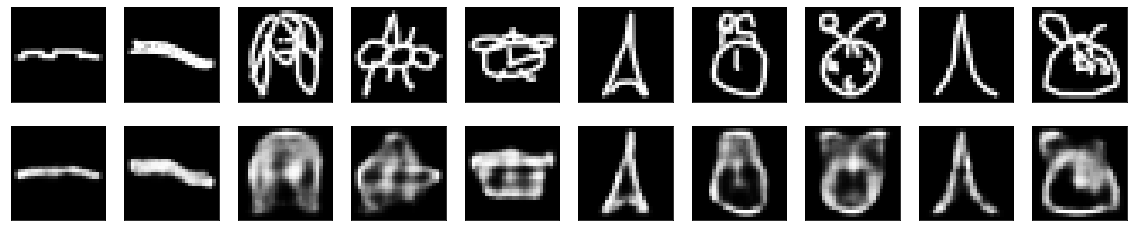

In [22]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [23]:
# we need to transfor our row vectors back into matrices
# because the convolutional and pooling layers expect images in the form of matrices 
x_train = x_train.reshape((x_train.shape[0], 28, 28))

In [24]:
x_train[0].shape

(28, 28)

### Example Image of a Conv Autoencoder 

![](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)

In [25]:
4 * 4* 8

128

In [30]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

# YOUR CODE HERE

# Our model architecture we're building here is meant to mimic the image above
# define some paramters || dims of each, individual sample
input_shape = (28,28, 1)

# weight matrix parameters
weight_matrix_size = (3,3)
pooling_size = (2,2)

# input layer 
inputs=Input(shape=input_shape)

# All these encoded variables are being assigning the output and passing
# it into the next as an input until we reach the end

# encoding layers. 16 weight matrices which will output 16 map matrices
encoded = Conv2D(16, weight_matrix_size, activation="relu", padding="same")(inputs)
encoded = MaxPooling2D(pooling_size, padding="same")(encoded)

encoded = Conv2D(8, weight_matrix_size, activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(pooling_size, padding="same")(encoded)

# padding="same" means there are the same amount of values on both sides
encoded = Conv2D(8, weight_matrix_size, activation="relu", padding="same")(encoded)
# At this point the data is in the following shape. (4,4,8)
# 4 by 4 matrix with 8 of them stacked ontop of each other (Rank 4 Tensor)
encoded = MaxPooling2D(pooling_size, padding="same")(encoded)
# flatten 3D tensor into 1D vector in preperation for the Dense layer
encoded_vect = Flatten()(encoded)
# 128 = 4*4*8
encoded_vect = Dense(128, activation="relu")(encoded_vect)

# Reshaping 1D vectors into 2D matrices
# Convolutional layers expect a 2D input, this is why we are juggling 
# these shapes back and forth
encoded = Reshape((4,4,8))(encoded_vect)

### decoding layers ###
decoded = Conv2D(8, weight_matrix_size, activation="relu", padding="same")(encoded)
decoded = UpSampling2D(pooling_size)(decoded)
decoded = Conv2D(8, weight_matrix_size, activation="relu", padding="same")(decoded)
decoded = UpSampling2D(pooling_size)(decoded)
decoded = Conv2D(16, weight_matrix_size, activation="relu")(decoded)
decoded = UpSampling2D(pooling_size)(decoded)
# because this is the final reconstruction of the original image
# we must necessarily use a single weight matrix for the convolution 
# so that the final output is a 2D matrix and not a rank 3 Tensor (i.e. a volume)
decoded = Conv2D(1, weight_matrix_size, activation="sigmoid", padding="same")(decoded)
# bring it all together using the Mode API
conv_autoencoder = Model(inputs=inputs, outputs=decoded, name="conv_autoencoder")


In [31]:
conv_autoencoder.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)      

In [32]:
# compile & fit model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os
import datetime

conv_autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

logdir = os.path.join("logs", f"ConvolutionalAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

conv_autoencoder.fit(x_train, 
                     x_train,
                     epochs=50,
                     batch_size=32,
                     shuffle=True,
                     validation_split=.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/50
2500/2500 [==============================] - 30s 6ms/step - loss: 0.2582 - val_loss: 0.2308
Epoch 2/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2219 - val_loss: 0.2194
Epoch 3/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2104 - val_loss: 0.2060
Epoch 4/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2037 - val_loss: 0.2005
Epoch 5/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1992 - val_loss: 0.1999
Epoch 6/50
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1960 - val_loss: 0.1944
Epoch 7/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1935 - val_loss: 0.1932
Epoch 8/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1915 - val_loss: 0.1912
Epoch 9/50
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1898 - val_loss: 0.1907
Epoch 10/50
2500/2500 [==============================] - 15s 6ms/step - l

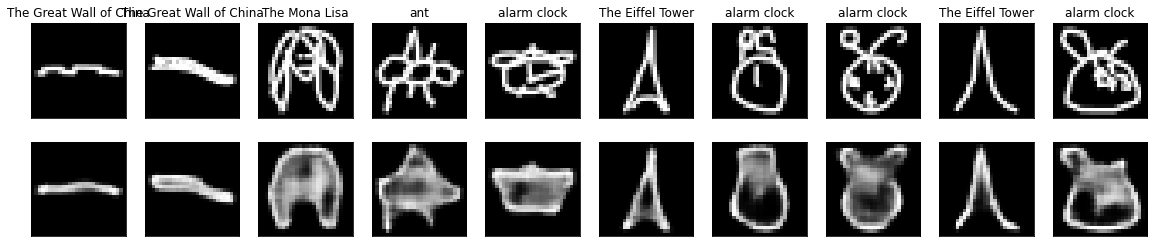

In [33]:
import matplotlib.pyplot as plt

decoded_imgs = conv_autoencoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Visualization of the Representations

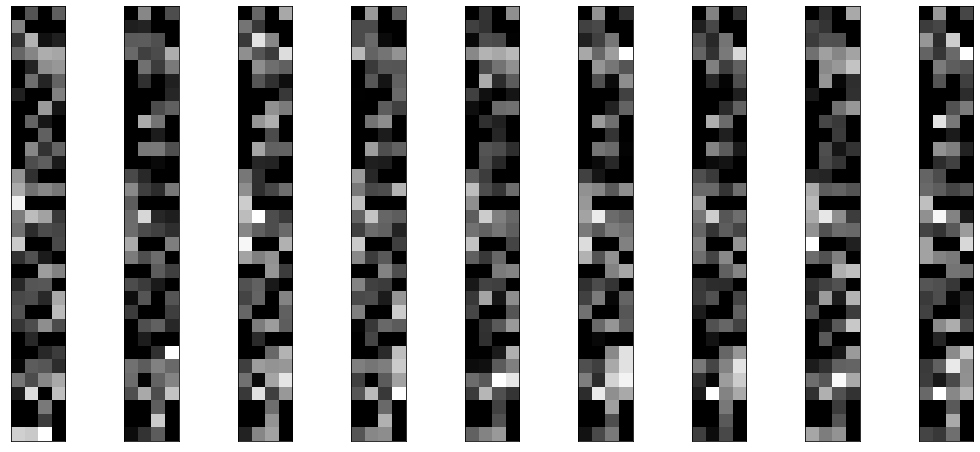

In [34]:
# we have isolated the encoder portion of our auto-encoder so that we can access the encoder vector (i.e. the output of the encoder)
encoder = Model(inputs=inputs, outputs=encoded)

# the predictions (i.e. the output) of our encoder model are the original images encoder into a smaller dim space (i.e. the encoder vectors)
encoded_imgs = encoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# these images are the encoded vectors for some of the images in the x_train
# notice that we really can't interpret them, this is the price we pay for non-linear dimentionality reduction
# the features in the encoded vectors are non-linear combinations of the input features
# this is the same give and take that we make with PCA - which is linear dimentionality reduction
# here's the link for the cool interactive visual for PCA that I used in class: https://setosa.io/ev/principal-component-analysis/

# What we pick up in extra dimensions, we lose in intepretability
# We use auto encoders for dimensionality reduction analagous to PCA

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

We are going to perform the following: 

- Build an encoder model
- Train a NearestNeighbors on encoded images
- Choose a query image 
- Find similar encoded images using the trained NearestNeighbors model
- Check our results, make sure that the similar image is in fact similar 

### Build an encoder model

Use the `Model` class and the encoder layers to build an encoded model. Remember that we first need to train a full autoencoder model, which as an encoder and decoder, before we can "break off" the trained encoder portion. 

In [35]:
encoded.shape

TensorShape([None, 4, 4, 8])

In [38]:
# we have isolated the encoder portion of our auto-encoder so that we can access the encoder vector 
# (i.e. the output of the encoder)

# YOUR CODE HERE
encoded_flat = Flatten()(encoded)
# Inputs will be original images, output will be the flattened images
encoder = Model(inputs=inputs, outputs=encoded_flat)

# Model is creating 1D encoded images
encoded_imgs = encoder.predict(x_train)

In [39]:
# now we can pass in our row vectors into a NN model
encoded_imgs.shape

(100000, 128)

### Build a NearestNeighbors model

We need to train a NearestNeighbors model on the encoded images. 


In [40]:
from sklearn.neighbors import NearestNeighbors

# fit KNN on encoded images (i.e. the encoded vectors)
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
# pass in the encoded images (i.e. the encoded vectors )
nn.fit(encoded_imgs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

### Select a query image

We need to chose an image that we will pass into NearestNeighbors in order to find similar images. 

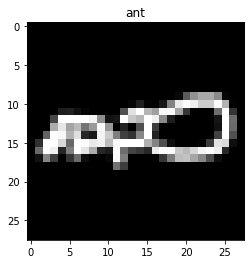

In [46]:
# get a query image 
query =  27

# this is the image that we want to pass into NearestNeighbors in order to find similar images 
# this will be done by looking at the distance between the encoder vectors of the images 
plt.title(class_names[y_train[query]])
plt.imshow(x_train[query]);

### Find Similar Images 
- Use the encoder to encode our query image
- Use NearestNeighbors to find similar images
- Check our results 

In [47]:
query_img = x_train[query]
query_img.shape

(28, 28)

In [48]:
# YOUR CODE HERE
query_img_reshaped = np.expand_dims(query_img, 0)
query_img_reshaped.shape

(1, 28, 28)

In [49]:
# encode query image using encoder model
query_img_encoded = encoder.predict(query_img_reshaped)

In [50]:
query_img_encoded.shape

(1, 128)

In [51]:
neigh_dist, neigh_ind = nn.kneighbors(query_img_encoded)

In [53]:
neigh_dist.round(3)[0][1:]
# Rounding to the third decimal place make this array easier to read

array([3.85 , 3.854, 3.903, 4.006, 4.075, 4.092, 4.157, 4.178, 4.202])

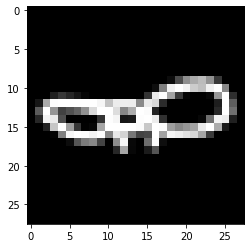

In [66]:
nearest_neight_index = neigh_ind[0][1:][3]
# Last bracket number allows us to query whatever image we want (within a range of 0,8)
plt.imshow(x_train[nearest_neight_index]);

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Enocder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__